In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import librosa
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
import seaborn as sns
import os
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

In [3]:
class AudioProcessing:
    def __init__(self, audio_filepath_snoring, audio_filepath_non_snoring):
        self.audio_filepath_snoring = audio_filepath_snoring
        self.audio_filepath_non_snoring = audio_filepath_non_snoring

    def load_dataFrame(self, audio_filepath, label, class_id):
        file_pattern = '*.wav'
        file_names = []
        labels = []
        file_paths = glob.glob(os.path.join(audio_filepath, '**', file_pattern), recursive=True)

        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            file_names.append(file_name)
            labels.append(label)

        data = {'audio': file_names, 'Labels': labels, "class_id": class_id}
        df = pd.DataFrame(data)

        return df

    def extract_mfcc_features(self, audio_data, sample_rate, num_mfcc=20, num_filter_banks=26):
        filter_banks = librosa.filters.mel(sr=sample_rate, n_fft=2048, n_mels=num_filter_banks)
        filter_banks_features = np.dot(filter_banks, np.abs(librosa.stft(audio_data))**2.0)

        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(filter_banks_features), n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_features = np.concatenate((mfcc_mean, mfcc_std))
        return mfcc_features

    def snoring_visualization(self):
        df_snoring = self.load_dataFrame(self.audio_filepath_snoring, "snoring", 1)
        audio_data_snoring = []
        sample_rate_snoring = []
        features_snoring=[]

        for index, row in df_snoring.iterrows():
            audio_file = row['audio']
            audio_file_path = os.path.join(self.audio_filepath_snoring, audio_file)
            audio_data, sample_rate = librosa.load(audio_file_path)
            audio_data_snoring.append(audio_data)
            sample_rate_snoring.append(sample_rate)
            
            # Extract MFCC features
            mfcc_features = self.extract_mfcc_features(audio_data, sample_rate)
            features_snoring.append(mfcc_features)

        df_snoring['Audio_Data'] = audio_data_snoring
        df_snoring['Sample_Rate'] = sample_rate_snoring
        df_snoring['Features'] = features_snoring

        # Display audio
        display(Audio(audio_data_snoring[0], rate=sample_rate_snoring[0]))

        # Wave plot for snoring
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio_data_snoring[0], alpha=0.25)
        plt.title("Wave Plot for Snoring")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()


        # Plot the FFT
        plt.figure(figsize=(8, 4))
        fft = np.fft.fft(audio_data_snoring[0])
        magnitude = np.abs(fft)
        frequency = np.linspace(0, sample_rate_snoring, len(magnitude))
        #half_spectrum = fft[:int(len(fft) / 2)]
        #half_frequency = frequency[:int(len(fft)/2)]
        plt.plot(frequency[:len(frequency) // 2], magnitude[:len(frequency) // 2])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('FFT of Snoring Audio')
        plt.show()

        # Plot the spectrogram
        plt.figure(figsize=(10, 4))
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data_snoring[0])), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sample_rate_snoring[0], x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram of Snoring Audio')
        plt.show()

        # Plot MFFC
        features_snoring = np.array(features_snoring)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(features_snoring.T, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('MFCC Features')
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficients')
        plt.show()

        df_snoring.to_csv('../dataset/csv/snoring_data.csv', index=False)

        return df_snoring


    def non_snoring_visualization(self):
        df_non_snoring = self.load_dataFrame(self.audio_filepath_non_snoring, "non-snoring", 0)
        audio_data_non_snoring = []
        sample_rate_non_snoring = []
        features_non_snoring = []
        

        for index, row in df_non_snoring.iterrows():
            audio_file = row['audio']
            audio_file_path = os.path.join(self.audio_filepath_non_snoring, audio_file)
            audio_data, sample_rate = librosa.load(audio_file_path)
            audio_data_non_snoring.append(audio_data)
            sample_rate_non_snoring.append(sample_rate)

            # Extract MFCC features
            mfcc_features = self.extract_mfcc_features(audio_data, sample_rate)
            features_non_snoring.append(mfcc_features)

        df_non_snoring['Audio_Data'] = audio_data_non_snoring
        df_non_snoring['Sample_Rate'] = sample_rate_non_snoring
        df_non_snoring['Features'] = features_non_snoring

        display(Audio(audio_data_non_snoring[0], rate=sample_rate_non_snoring[0]))

        # Waveform plot for non snoring
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio_data_non_snoring[99], alpha=0.25)
        plt.title("Wave plot for non-snoring")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()

        # FFT for non-snoring Audio
        plt.figure(figsize=(8, 4))
        fft = np.fft.fft(audio_data_non_snoring[99])
        magnitude = np.abs(fft)
        frequency = np.linspace(0, sample_rate_non_snoring, len(magnitude))
        plt.plot(frequency[:len(frequency) // 2], magnitude[:len(frequency) // 2])

        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('FFT of Non Snoring Audio')
        plt.show()

        # Plot the spectrogram
        plt.figure(figsize=(10, 4))
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data_non_snoring[99])), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sample_rate_non_snoring[0], x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram of Non-Snoring Audio')
        plt.show()

        features_non_snoring = np.array(features_non_snoring)

        # Plot MFCC
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(features_non_snoring.T, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('MFCC Features')
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficients')
        plt.show()

        df_non_snoring.to_csv('../dataset/csv/non_snoring_data.csv', index=False)

        return df_non_snoring

    def merge_dataframe(self):
        df_snoring = pd.read_csv("../dataset/csv/snoring_data.csv")
        df_non_snoring = pd.read_csv("../dataset/csv/non_snoring_data.csv")
        df = pd.concat([df_snoring, df_non_snoring])

        df['Features'] = df['Features'].apply(lambda x: np.array(x.strip('[]').split()).astype(float))

        # Prepare df for model building
        df.drop(columns=['audio', 'Labels', 'Audio_Data', 'Sample_Rate'], inplace=True)
        return df

    def train_model(self):
        df = self.merge_dataframe()
        X = df['Features'].to_list()
        y = df['class_id']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Convert X_train and X_test to numpy arrays
        X_train = np.array(X_train)
        X_test = np.array(X_test)

        # Reshape X_train and X_test to 2D arrays (required for StandardScaler)
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        # Initialize standard scaler
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.fit_transform(X_test)

        classifier = SVC(kernel='rbf')
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        # Save model using pickle
        with open("../models/classifier.pkl", 'wb') as model_file:
            pickle.dump(classifier, model_file)

        
        cm = confusion_matrix(y_test, y_pred)
        # Create a heatmap of the confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        report = classification_report(y_test, y_pred, target_names=['Non-Snoring', 'Snoring'])
        print("Classification Report:\n", report)

        # Create a classification report
        report = classification_report(y_test, y_pred, target_names=['Non-Snoring', 'Snoring'])
        print("Classification Report:\n", report)

        # Visualize the classification report as a heatmap
        report_dict = classification_report(y_test, y_pred, target_names=['Non-Snoring', 'Snoring'], output_dict=True)
        sns.heatmap(pd.DataFrame(report_dict).T, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.xlabel("Metrics")
        plt.ylabel("Classes")
        plt.title("Classification Report Heatmap")
        plt.show()
        
        # Create a scatter plot for the predictions
        colors = {'Non-Snoring': 'blue', 'Snoring': 'orange'}
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test.index, y=y_test, hue=y_pred, palette='Set2')
        plt.xlabel("Sample Index")
        plt.ylabel("Predicted Class")
        plt.title("Scatter Plot of Sample Index vs. Predicted Class")
        plt.xticks(rotation=45)
        plt.legend(title="Predicted Class", loc='upper right')
        plt.show()


In [4]:
audio_filepath_snoring = '../data/1/'
audio_filepath_non_snoring = '../data/0/'
preprocessing = AudioProcessing(audio_filepath_snoring, audio_filepath_non_snoring)

### Process Non-Snoring Audio

The `process_non_snoring` method loads and processes the non-snoring audio files.

#### Steps:
1. Load the non-snoring audio files and create an empty list for audio data, sample rates, and features.
2. Iterate over each non-snoring audio file:
   - Load the audio data and sample rate using librosa.
   - Append the audio data and sample rate to their respective lists.
   - Extract MFCC features from the audio data and append them to the features list.
3. Create columns in the dataframe to store the audio data, sample rates, and features.
4. Display the audio waveform, FFT, spectrogram, and MFCC features for a selected non-snoring audio file.
5. Return the dataframe containing the non-snoring audio information.

**Inputs:**
- `audio_filepath_non_snoring`: Path to the directory containing non-snoring audio files.

**Outputs:**
- `df_non_snoring`: DataFrame containing information about the non-snoring audio files.

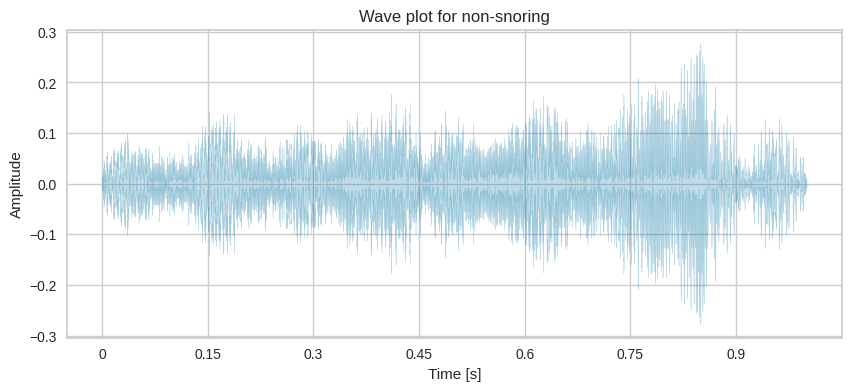

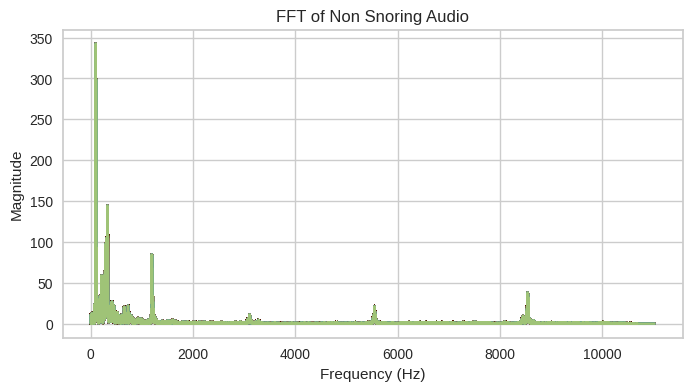

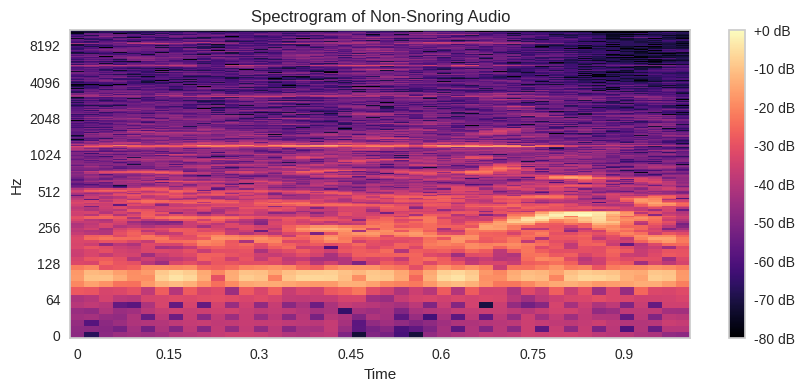

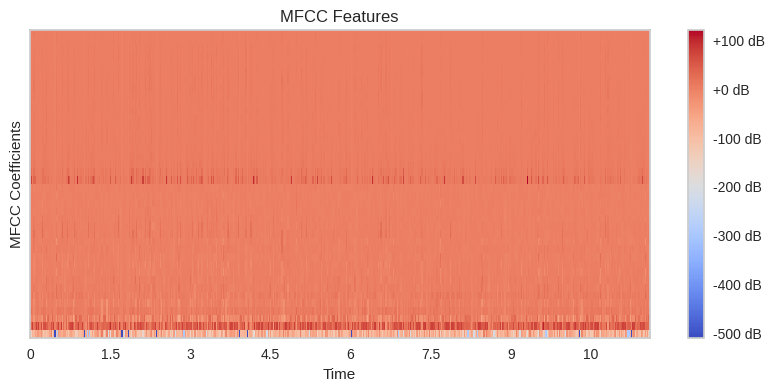

,audio,Labels,class_id,Audio_Data,Sample_Rate,Features
0,0_443.wav,non-snoring,0,"[0.010056222, 0.01763131, 0.017754827, 0.02234...",22050,"[-80.074326, 76.215645, 2.097256, 7.245966, 5...."
1,0_145.wav,non-snoring,0,"[0.0013398648, 0.0035494901, 0.003185474, -0.0...",22050,"[-143.84288, 33.003483, -5.603544, 15.00129, 0..."
2,0_435.wav,non-snoring,0,"[0.05555623, 0.08908294, 0.09494937, 0.1068091...",22050,"[-77.640495, 77.142365, 0.47089994, 3.8636117,..."
3,0_26.wav,non-snoring,0,"[-0.059850503, -0.08772577, -0.07480897, -0.06...",22050,"[-93.93284, 16.332756, -30.20479, -9.026626, -..."
4,0_159.wav,non-snoring,0,"[0.013063112, -0.0014051758, 0.000903612, 0.00...",22050,"[-45.598446, 35.134033, -4.7199464, 4.976124, ..."
...,...,...,...,...,...,...
495,0_383.wav,non-snoring,0,"[-0.027183417, -0.043856286, -0.040156003, -0....",22050,"[-112.4634, 66.37732, 12.222937, 9.967891, 8.0..."
496,0_210.wav,non-snoring,0,"[0.1489392, 0.40068424, 0.52296877, 0.5689255,...",22050,"[-38.472214, 22.858627, -19.069754, -2.1335213..."
497,0_63.wav,non-snoring,0,"[0.0032755435, -0.004902441, 0.00053747743, 0....",22050,"[-104.00484, 34.343506, 25.884758, 5.2839007, ..."
498,0_319.wav,non-snoring,0,"[-0.04302994, -0.054257743, 0.010951683, 0.006...",22050,"[-41.15906, 25.90417, 3.9765577, 9.3349085, 6...."


In [5]:
preprocessing.non_snoring_visualization()

### Process Snoring Audio

The `process_snoring` method loads and processes the snoring audio files.

#### Steps:
1. Load the non-snoring audio files and create an empty list for audio data, sample rates, and features.
2. Iterate over each snoring audio file:
   - Load the audio data and sample rate using librosa.
   - Append the audio data and sample rate to their respective lists.
   - Extract MFCC features from the audio data and append them to the features list.
3. Create columns in the dataframe to store the audio data, sample rates, and features.
4. Display the audio waveform, FFT, spectrogram, and MFCC features for a selected snoring audio file.
5. Return the dataframe containing the snoring audio information.

**Inputs:**
- `audio_filepath_snoring`: Path to the directory containing snoring audio files.

**Outputs:**
- `df_snoring`: DataFrame containing information about the snoring audio files.

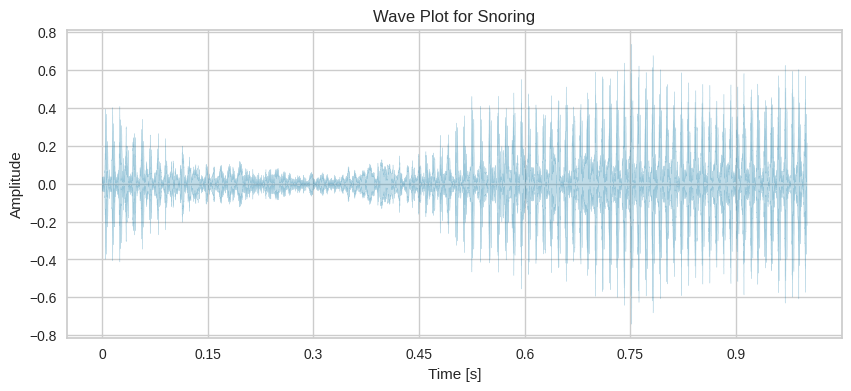

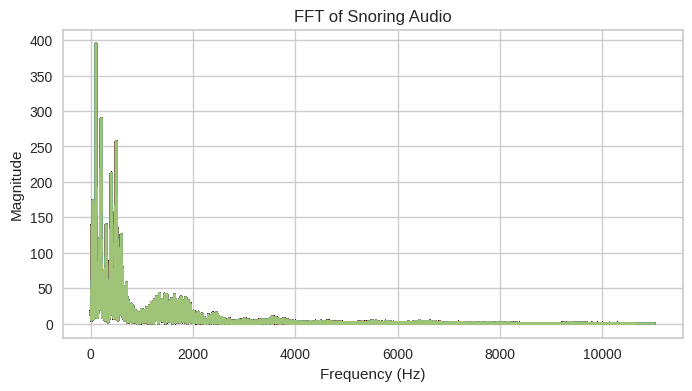

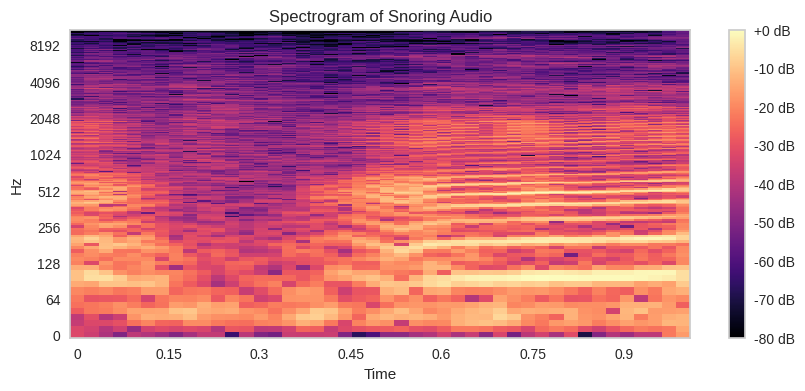

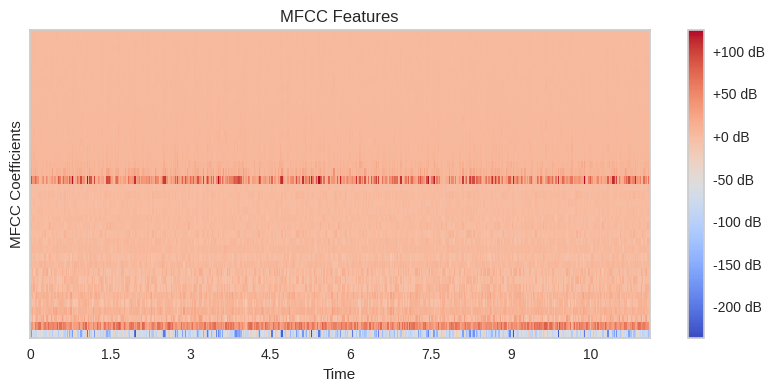

,audio,Labels,class_id,Audio_Data,Sample_Rate,Features
0,1_152.wav,snoring,1,"[0.01759163, 0.030713446, 0.035117146, 0.03838...",22050,"[-56.679306, 62.014004, -3.0282328, 11.6422415..."
1,1_41.wav,snoring,1,"[-0.005157121, -0.008157655, -0.017428868, -0....",22050,"[-171.90852, 35.947403, -4.769685, 8.634753, 1..."
2,1_416.wav,snoring,1,"[0.00047056354, 0.003505517, 0.004637032, -0.0...",22050,"[-66.533806, 39.69775, 12.166776, 16.132318, -..."
3,1_284.wav,snoring,1,"[-7.518218e-06, 0.0010837276, 0.0052734106, 0....",22050,"[-78.420784, 15.791531, -14.943543, 4.137115, ..."
4,1_296.wav,snoring,1,"[-0.11237783, -0.092689365, 0.033580005, 0.106...",22050,"[-87.07702, 63.283154, 1.5715104, 11.265655, 1..."
...,...,...,...,...,...,...
495,1_354.wav,snoring,1,"[-0.26331192, -0.4181184, -0.41228408, -0.4732...",22050,"[-88.05206, 61.021854, 1.4985219, 13.121245, 8..."
496,1_253.wav,snoring,1,"[0.04765732, 0.07062198, 0.075576544, 0.085236...",22050,"[-71.8095, 49.675236, 20.474709, 7.9029384, 9...."
497,1_390.wav,snoring,1,"[-0.6074817, -0.89055824, -0.8405086, -0.94998...",22050,"[-79.78298, 41.67839, 23.814917, 6.2931004, 10..."
498,1_25.wav,snoring,1,"[0.001435118, 0.0060089445, 0.012261318, 0.009...",22050,"[-90.110954, 43.357487, -1.3165314, 8.105624, ..."


In [6]:
preprocessing.snoring_visualization()

### Concatenate df_non_snoring.csv and df_snoring.csv


In [7]:
df = preprocessing.merge_dataframe()

In [8]:
audio, sr = librosa.load("../output_audio(1).wav")

In [9]:
features = preprocessing.extract_mfcc_features(audio, sr)

In [10]:
print(features)

[-248.98866      15.744344     15.652395     15.500393     15.28875
   15.018662     14.691576     14.309224     13.8736       13.386916
   12.851611     12.270262     11.645618     10.980503     10.277858
    9.540646      8.771887      7.974584      7.1517572     6.3063765
    1.4668419     2.0131793     1.985907      1.9464555     1.8928968
    1.8264533     1.7490739     1.6627088     1.5696096     1.471972
    1.3720022     1.2716774     1.1727315     1.0764728     0.9837701
    0.89495647    0.80988795    0.7279754     0.64834183    0.5699512 ]


In [11]:
with open("../models/classifier.pkl", 'rb') as classifier:
    classifier = pickle.load(classifier)

clsas = classifier.predict([features])
print(clsas)

[0]


In [12]:
df.tail()

,class_id,Features
495,0,"[-112.4634, 66.37732, 12.222937, 9.967891, 8.0..."
496,0,"[-38.472214, 22.858627, -19.069754, -2.1335213..."
497,0,"[-104.00484, 34.343506, 25.884758, 5.2839007, ..."
498,0,"[-41.15906, 25.90417, 3.9765577, 9.3349085, 6...."
499,0,"[-133.0625, 29.229815, 32.406799, 10.318868, 0..."


In [13]:
df.head()

,class_id,Features
0,1,"[-56.679306, 62.014004, -3.0282328, 11.6422415..."
1,1,"[-171.90852, 35.947403, -4.769685, 8.634753, 1..."
2,1,"[-66.533806, 39.69775, 12.166776, 16.132318, -..."
3,1,"[-78.420784, 15.791531, -14.943543, 4.137115, ..."
4,1,"[-87.07702, 63.283154, 1.5715104, 11.265655, 1..."


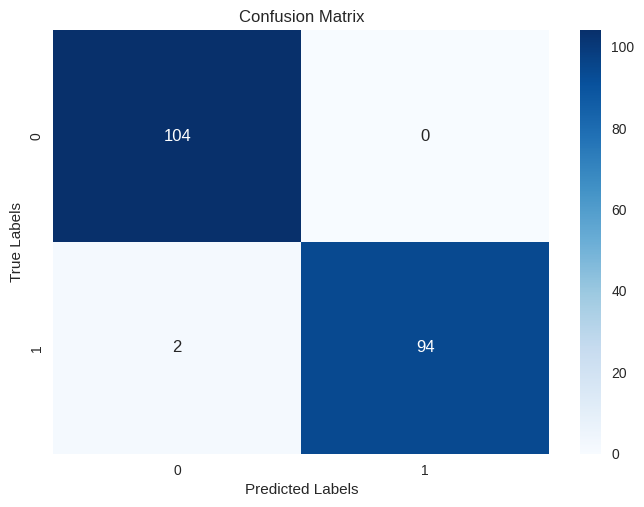

Classification Report:
               precision    recall  f1-score   support

 Non-Snoring       0.98      1.00      0.99       104
     Snoring       1.00      0.98      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Classification Report:
               precision    recall  f1-score   support

 Non-Snoring       0.98      1.00      0.99       104
     Snoring       1.00      0.98      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



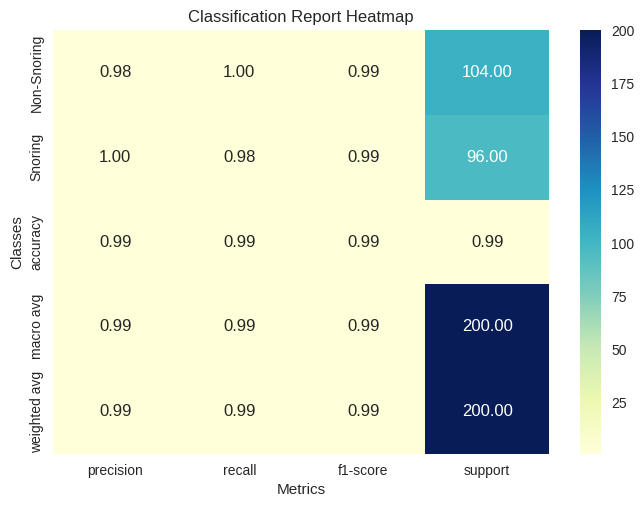

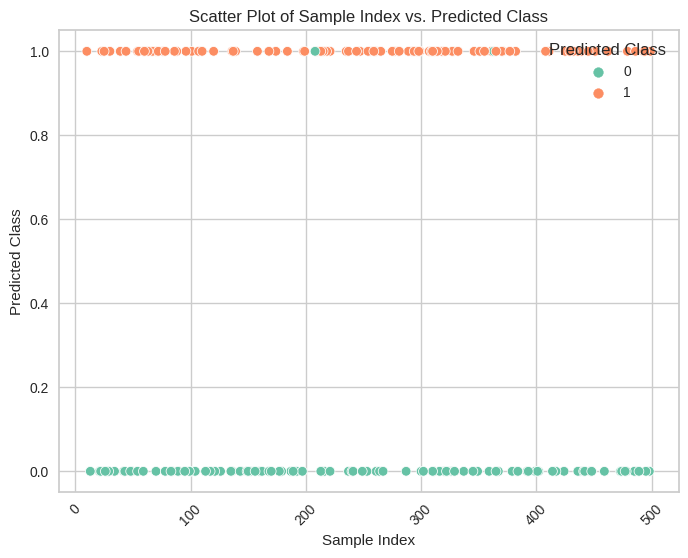

In [14]:
preprocessing.train_model()

# Making sample predictions

In [15]:

segment_duration = 1
overlap = 0.5
audio, sample_rate = librosa.load("../data/1/1_41.wav")
segment_size = int(segment_duration * sample_rate)
hop_length = int(segment_size * (1 - overlap))
segment_features = []
predictions = []

scaler = StandardScaler()
# Extract MFCC features
with open("../models/classifier.pkl", "rb") as model_file:
    model = pickle.load(model_file)
for i in range(0, len(audio) - segment_size + 1, hop_length):
    segment = audio[i : i + segment_size]  # Extract segment

    # Extract features from the segment (replace with your feature extraction method)
    segment_feature = preprocessing.extract_mfcc_features(audio_data = segment, sample_rate = sample_rate)
    
    # Normalize features using the same scaler used during training
    segment_feature_normalized = scaler.fit_transform([segment_feature])

    # Make prediction using the SVM model
    prediction = model.predict(segment_feature_normalized)
    predictions.append(prediction)

# Aggregate predictions as needed (e.g., majority vote, average)
final_prediction = np.mean(predictions)  # Adjust aggregation strategy

# Print or use the final prediction as needed
if final_prediction == 0:
    print("Snoring not detected")

Snoring not detected


In [16]:
audio_file = "../output_audio(1).wav"
audio, sample_rate = librosa.load(audio_file)
# Calculate the total number of seconds
total_seconds = len(audio) / sample_rate

# Define the segment duration
segment_duration = 1  # 1 second

# Initialize a list to store segment predictions
segment_predictions = []

# Segment the audio and extract features for each segment
for i in range(0, int(total_seconds), segment_duration):
    start_sample = i * sample_rate
    end_sample = start_sample + segment_duration * sample_rate
    segment = audio[start_sample:end_sample]

    # Extract features from the segment (replace this with your feature extraction method)
    segment_features = preprocessing.extract_mfcc_features(segment, sample_rate)
    segment_predictions.append(segment_features)

# Convert the list of segment predictions to a numpy array
segment_predictions_array = np.array(segment_predictions)

# Reshape the array for SVM input
reshaped_features = segment_predictions_array.reshape(segment_predictions_array.shape[0], -1)

# Standardize the features
sc_X = StandardScaler()
X_test = sc_X.fit_transform(reshaped_features)

# Make predictions using the SVM model
predictions = model.predict(X_test)
    

# Plot of the auido data with the snoring area shaded
Visualize the time at which snoring occurs at a given time interval

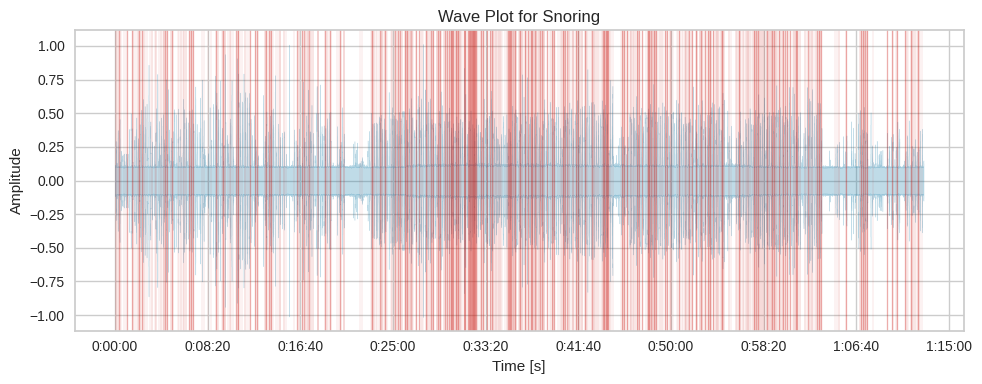

In [24]:
snoring_indices = [i for i, prediction in enumerate(predictions) if prediction == 1]

# Create the waveform plot using librosa.display.waveshow()
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, alpha=0.25)

# Shade regions where snoring is predicted for each second
segment_duration = 1  # 1 second
for i in snoring_indices:
    start_time = i * segment_duration
    end_time = (i + 1) * segment_duration
    plt.axvspan(start_time, end_time, color='r', alpha=0.25)

plt.title("Wave Plot for Snoring")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [19]:
predictions

array([0, 0, 0, ..., 0, 0, 0])